# LNLN model analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Model Description

[Link to model code](https://github.com/jzlab/v1_predictor/blob/3b435e0f53ab3cad4d4e1c5cfabe99939c62da21/src/buildnet.py#L25)


Input shape/Image Vector: 1089 (flattened image, 33x33)

- 1st LN Layer
    - Input shape = 1089
    - Output shape = One of either [150,250,350,500,900]

- 2nd LN Layer
    - Input shape = One of either [150,250,350,500,900]
    - Output shape = 37 (number of cells in kohn dataset 02)

### Trial Structure
- Learning Rate: 0.001
- Max Steps: 60k
- Early Stop Fraction: 1/7
- 7 trials each with num_units=[150,250,350,500,900]


In [2]:
filepaths = []
def rec_iter(data_root,labels=None):
    # Get list of num units from dir names in data_root
    num_units = [int(n) for n in os.listdir(data_root)]
    
    # Get list of files in each dir
    files = [os.listdir(os.path.join(data_root,str(n))) for n in num_units]
    
    # Filter out non-person data files
    files = [list(filter(lambda k: 'person' in k, f)) for f in files]
    
    # Generator loop
    for n,fs in zip(num_units,files):
        paths = [os.path.join(data_root,str(n),f) for f in fs]
        for trial,fp in enumerate(paths):
            # [rval,step,loss_per_nueron_eval,lossbaselinenueron, evalvar,traintrials,earlystoptrials,evaltrials,FLAGS]
            r,step,loss,_loss,var,_,_,_,FLAGS = np.load(fp)
            num_neur = len(r)
            for neuron_rec in zip(np.arange(num_neur)+1,r,loss,_loss,var):
                
                vals = neuron_rec + (step,n,FLAGS.earlystop_frac,FLAGS.fileindex+1,FLAGS.learning_rate,trial+1)
                if labels is None:
                    yield vals
                else:
                    yield {k:v for k,v in zip(labels,vals)}  

### Load Data

In [3]:
data_root = '/home/elijahc/dev/v1_predictor/lnln_hyperopt/'
labels = ('neuron','r_eval','loss','baseline_loss','variance','step','num_units','earlystop_frac','fileindex','learning_rate','trial')

recs = rec_iter(data_root,labels)

lnln_df = pd.DataFrame.from_records(list(recs))
lnln_df.head()

,baseline_loss,earlystop_frac,fileindex,learning_rate,loss,neuron,num_units,r_eval,step,trial,variance
0,0.190052,0.142857,2,0.001,0.269289,1,375,0.000000e+00,22500,1,0.167910
1,0.132634,0.142857,2,0.001,0.163466,2,375,3.703917e-01,22500,1,0.132244
2,0.167988,0.142857,2,0.001,0.133230,3,375,4.295563e-01,22500,1,0.167924
3,0.005279,0.142857,2,0.001,0.007356,4,375,1.251734e-16,22500,1,0.005069
4,0.276602,0.142857,2,0.001,0.638765,5,375,2.861973e-01,22500,1,0.275410


### Scatter plots of raw data
Grouped by number of outputs of first LN layer

Each dot is the correlation([pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)) of a neuron from a trial on the held-out evaluation images

Each column has roughly 37(neurons) x 7(trials) datapoints

In [4]:
sns.set_context('talk')

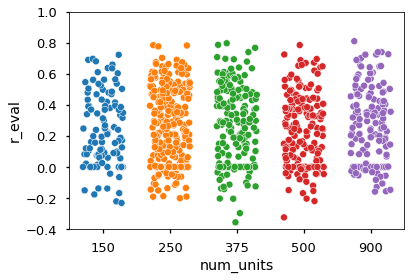

In [5]:
sns.stripplot(x='num_units',y='r_eval',data=lnln_df,jitter=.3,linewidth=0.5,edgecolor='white',size=7)
r_ylim = (-0.4,1.0)
plt.ylim(r_ylim);

### What's the distribution for each trial?

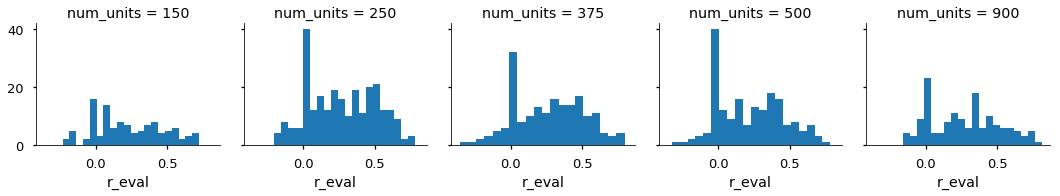

In [6]:
g = sns.FacetGrid(lnln_df,col='num_units')
g = g.map(plt.hist, 'r_eval',bins=20)

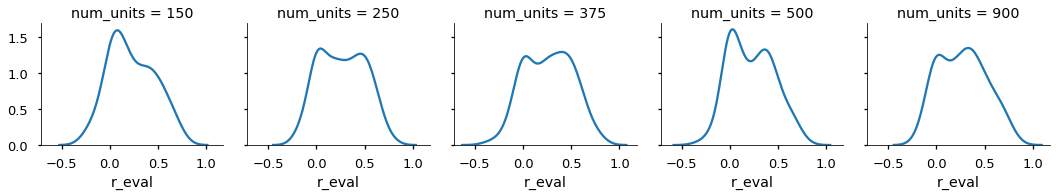

In [7]:
g = sns.FacetGrid(lnln_df,col='num_units')
g = g.map(sns.kdeplot, 'r_eval')

### Violin Plot
> (i.e. boxplot with KDE overlaid)

- Thick bar: IQR
- Thin bar: Actual range of all values
- White Dot: mean

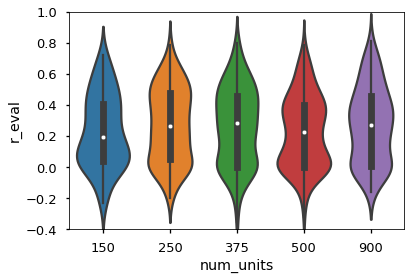

In [8]:
sns.violinplot(x='num_units',y='r_eval',data=lnln_df,jitter=True)
plt.ylim(r_ylim);

### Within a trial what is the mean r across all neurons?

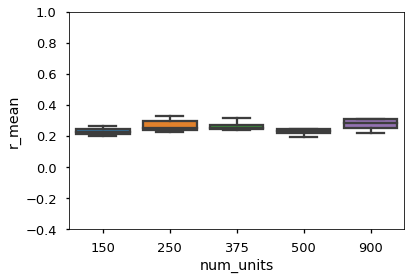

In [9]:
r_mean = lnln_df.groupby(['num_units','trial']).mean().r_eval
sns.boxplot(x='num_units',y='r_eval',data=r_mean.reset_index())
plt.ylim(r_ylim)
plt.ylabel('r_mean');

r_mean using 250 is about the same as 375 and 250 will train faster so I'll use 250 units for evaluating the other datasets